In [2]:
import jax
import jax.numpy as jnp
import optax


import matplotlib.pyplot as plt
import numpy as np


from tqdm import tqdm as tqdm
import pandas as pd


import time

In [3]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):


    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))


    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    
    return samples

In [4]:
def potential_grad(sample, mu, cov):


    precision = jnp.linalg.inv(cov)


    return (sample - mu) @ precision

In [5]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=100, seed=0):

    
    key = jax.random.PRNGKey(seed)
    evolved_samples = samples


    for i in range(n_evolution):
        key, subkey = jax.random.split(key)
        grad = potential_grad(evolved_samples, mu, cov)
        noise = jax.random.normal(subkey, shape=evolved_samples.shape)
        evolved_samples = evolved_samples - eps * grad + jnp.sqrt(2 * eps) * noise
        

    return evolved_samples

In [6]:
def compute_energy_distance(samples, evolved_samples):
    n = samples.shape[0]
    m = evolved_samples.shape[0]


    def pairwise_l2_norm(a, b):
        a_norm = jnp.sum(a**2, axis=1).reshape(-1, 1)
        b_norm = jnp.sum(b**2, axis=1).reshape(1, -1)
        sq_dists = a_norm + b_norm - 2 * a @ b.T
        return jnp.sqrt(jnp.maximum(sq_dists, 1e-10))


    d_xy = pairwise_l2_norm(samples, evolved_samples)
    d_xx = pairwise_l2_norm(samples, samples)
    d_yy = pairwise_l2_norm(evolved_samples, evolved_samples)


    ed = (
        2 * jnp.sum(d_xy) / (n * m)
        - jnp.sum(d_xx) / (n * n)
        - jnp.sum(d_yy) / (m * m)
    )


    return ed

In [7]:
def lm_loss(samples, mu, cov):


    evolved_samples = evolve_langevin(samples, mu, cov)


    return compute_energy_distance(samples, evolved_samples)

In [8]:
def lm_optimize(samples, n_epochs=1000, lr=1e-2, seed=10, eps=1e-2, plot_every=2):


    n, d = samples.shape


    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)


    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))


    params = {
        "mu": mu,
        "A": A
    }


    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)


    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)


    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)


        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")


    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]


    return final_mu, final_cov

In [9]:
def lm_optimize_with_tracking(
    samples,
    true_mu,
    true_cov,
    n_epochs=1000,
    base_lr=1e-2,
    seed=10,
    eps=1e-2,
    plot_every=1,
    use_lr_schedule=True
):
    

    n, d = samples.shape


    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)


    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))


    params = {
        "mu": mu,
        "A": A
    }


    if use_lr_schedule:
        lr_schedule = optax.linear_schedule(
            init_value=1e-2,
            end_value=base_lr,
            transition_steps=500
        )
        optimizer = optax.adam(learning_rate=lr_schedule)
    else:
        optimizer = optax.adam(learning_rate=base_lr)


    opt_state = optimizer.init(params)


    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)


    history = {
        "loss": [],
        "mu_l2": [],
        "cov_fro": [],
    }


    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)


        mu_val = params["mu"]
        A_val = params["A"]
        cov_val = A_val.T @ A_val


        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_val))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_val, ord='fro'))


        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")


    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]


    return final_mu, final_cov, history

In [10]:
mu = jnp.array([1.0])


cov = jnp.array([
[1.0]
])

In [11]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)


time_start = time.time()


final_mu, final_cov, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=800, base_lr=0.1, seed = 0)


time_end = time.time()
time_elapsed = time_end - time_start
time_round = time_elapsed/800
print(time_round)

epoch 0 | loss = 0.080379
epoch 1 | loss = 0.080050
epoch 2 | loss = 0.079711
epoch 3 | loss = 0.079366
epoch 4 | loss = 0.079012
epoch 5 | loss = 0.078654
epoch 6 | loss = 0.078284
epoch 7 | loss = 0.077905
epoch 8 | loss = 0.077517
epoch 9 | loss = 0.077117
epoch 10 | loss = 0.076704
epoch 11 | loss = 0.076278
epoch 12 | loss = 0.075840
epoch 13 | loss = 0.075388
epoch 14 | loss = 0.074924
epoch 15 | loss = 0.074444
epoch 16 | loss = 0.073951
epoch 17 | loss = 0.073446
epoch 18 | loss = 0.072923
epoch 19 | loss = 0.072384
epoch 20 | loss = 0.071831
epoch 21 | loss = 0.071259
epoch 22 | loss = 0.070669
epoch 23 | loss = 0.070058
epoch 24 | loss = 0.069431
epoch 25 | loss = 0.068782
epoch 26 | loss = 0.068115
epoch 27 | loss = 0.067423
epoch 28 | loss = 0.066711
epoch 29 | loss = 0.065972
epoch 30 | loss = 0.065211
epoch 31 | loss = 0.064422
epoch 32 | loss = 0.063606
epoch 33 | loss = 0.062762
epoch 34 | loss = 0.061890
epoch 35 | loss = 0.060992
epoch 36 | loss = 0.060057
epoch 37 | 

In [12]:
jnp.set_printoptions(precision=4, suppress=True)


print(jnp.round(mu, 4), "\n\n", jnp.round(final_mu, 4), jnp.linalg.norm(mu - final_mu)/jnp.linalg.norm(mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(final_cov, 4), jnp.linalg.norm(cov - final_cov)/jnp.linalg.norm(cov), "\n\n\n")

[1.] 

 [0.9535] 0.046459913 



[[1.]] 

 [[0.9397]] 0.060320973 





In [13]:
history_np = {k: np.array(v) for k, v in history.items()}

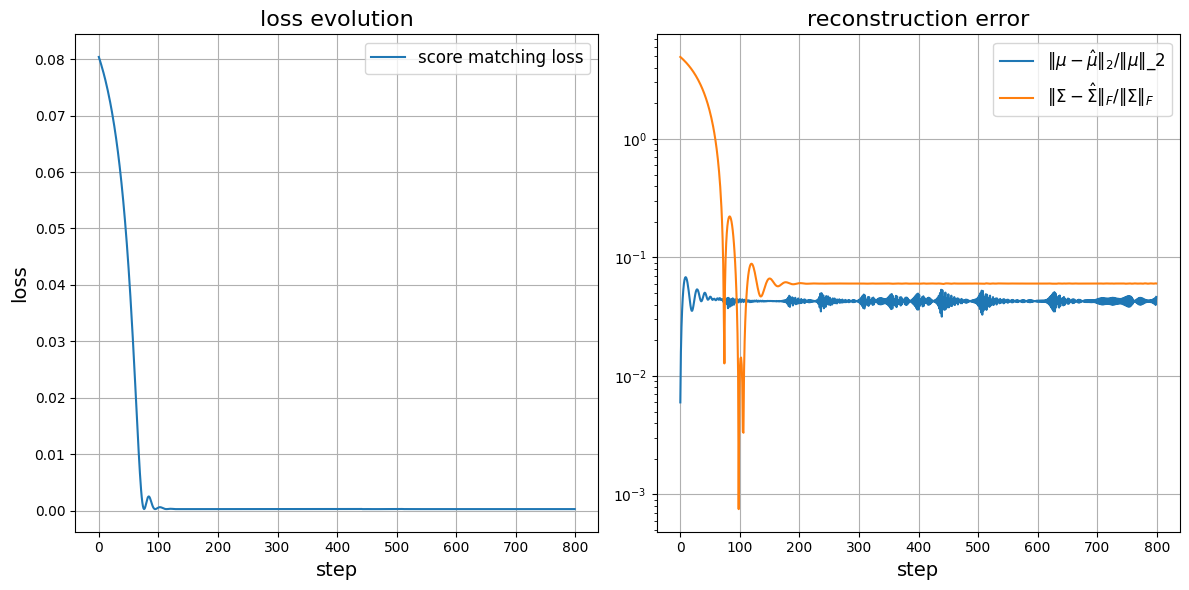

In [14]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="score matching loss")
plt.xlabel("step", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.title("loss evolution", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"]/np.linalg.norm(mu), label=r"$\| \mu - \hat{\mu} \|_2/\|\mu\|\_2$")
plt.plot(history_np["cov_fro"]/np.linalg.norm(cov), label=r"$\| \Sigma - \hat{\Sigma} \|_F/\|\Sigma\|_F$")
plt.yscale("log")
plt.xlabel("step", fontsize=14)
plt.title("reconstruction error", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.tight_layout()
plt.show()

In [15]:
sample_sizes = np.arange(50, 2001, 50)
n_steps = 800


all_losses = []
all_mu_errors = []
all_cov_errors = []


for n in tqdm(sample_sizes):
    samples = generate_gaussian_samples(mu, cov, n, seed=0)
    _, _, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=n_steps, base_lr=0.1, seed = 0)
    all_losses.append(np.array(history["loss"]))
    all_mu_errors.append(np.array(history["mu_l2"]))
    all_cov_errors.append(np.array(history["cov_fro"]))

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0 | loss = 0.059375
epoch 1 | loss = 0.058980
epoch 2 | loss = 0.058576
epoch 3 | loss = 0.058156
epoch 4 | loss = 0.057728
epoch 5 | loss = 0.057285
epoch 6 | loss = 0.056830
epoch 7 | loss = 0.056364
epoch 8 | loss = 0.055885
epoch 9 | loss = 0.055406
epoch 10 | loss = 0.054914
epoch 11 | loss = 0.054414
epoch 12 | loss = 0.053901
epoch 13 | loss = 0.053386


  0%|          | 0/40 [00:03<?, ?it/s]


KeyboardInterrupt: 

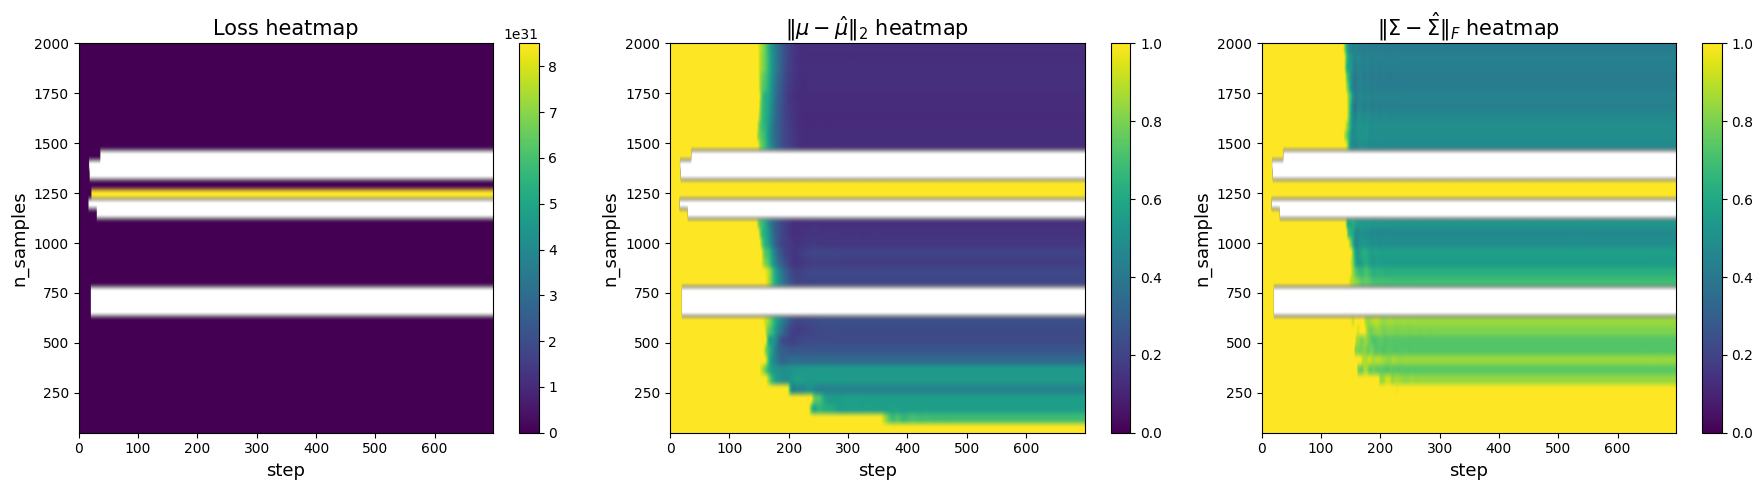

In [ ]:
loss_matrix = np.array(all_losses)
mu_err_matrix = np.array(all_mu_errors)/np.linalg.norm(mu)
cov_err_matrix = np.array(all_cov_errors)/np.linalg.norm(cov)


steps = np.linspace(0, n_steps, n_steps)
sample_sizes = np.arange(50, 2001, 50)


def plot_heatmap(data, title, ylabel, cmap="viridis", vmin=None, vmax=None):
    plt.imshow(data, aspect="auto", origin="lower", cmap=cmap,
               extent=[steps[0], steps[-1], sample_sizes[0], sample_sizes[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel("step", fontsize=13)
    plt.ylabel("n_samples", fontsize=13)
    plt.title(title, fontsize=15)


plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plot_heatmap(loss_matrix, "Loss heatmap", "n_samples")


plt.subplot(1, 3, 2)
plot_heatmap(mu_err_matrix, r"$\|\mu - \hat{\mu}\|_2/\|\mu\|_2$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.subplot(1, 3, 3)
plot_heatmap(cov_err_matrix, r"$\|\Sigma - \hat{\Sigma}\|_F/\|\Sigma\|_F$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.tight_layout()
plt.show()